In [1]:
import numpy as np

import pandas as pd
import tushare as ts # collect data
import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

mean=0.0008377491666733144,  std=0.018001933037586113
 sz50 skewness =-0.622373111042389 ;kurtosis = 5.819173088242997 


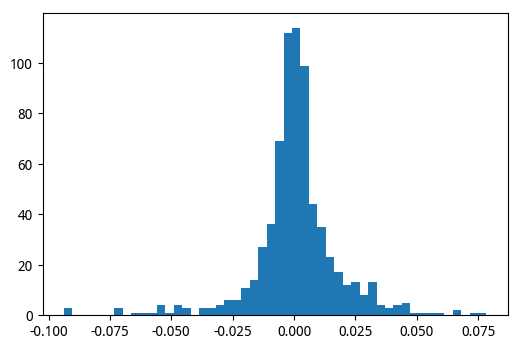

In [3]:
data=ts.get_hist_data('sz50',ktype='d',start='2000-10-01',end="2017-10-01")
# data[:2]
close_rate=(data.close-data.close.shift(-1))/data.close.shift(-1)
plt.hist(close_rate.dropna(),bins=50)
data=data[::-1]

print("mean={},  std={}".format(close_rate.mean(),close_rate.std()))
print(' {} skewness ={} ;kurtosis = {} '.format('sz50',close_rate.skew(),close_rate.kurtosis()))



In [4]:
data.head(2)

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20
date,,,,,,,,,,,,,
2014-11-03,1662.748,1664.432,1651.052,1646.434,589474.25,-6.234,-0.38,1651.052,1651.052,1651.052,589474.25,589474.25,589474.25
2014-11-04,1648.112,1650.808,1645.624,1639.678,583892.94,-5.428,-0.33,1648.338,1648.338,1648.338,586683.60,586683.60,586683.60


# magic code

In [5]:
##########################


data_to_computed=data[-2000:]

##########################



# clear data

In [6]:
close=data_to_computed.close

close=close.values.reshape(-1,1)

In [7]:
data.close[:4]

date
2014-11-03    1651.052
2014-11-04    1645.624
2014-11-05    1637.625
2014-11-06    1635.964
Name: close, dtype: float64

In [8]:
close[:4]

array([[ 1651.052],
       [ 1645.624],
       [ 1637.625],
       [ 1635.964]])

In [9]:
train_number=int(  len(close) *0.8  )

In [10]:
close_train=close[:train_number]

close_test=close[train_number:]

In [11]:
close_test.shape

(143, 1)

In [12]:
train_data_scaler = StandardScaler()  
train_data_scaler.fit(close_train)
scaled_traindata=train_data_scaler.transform(close_train)

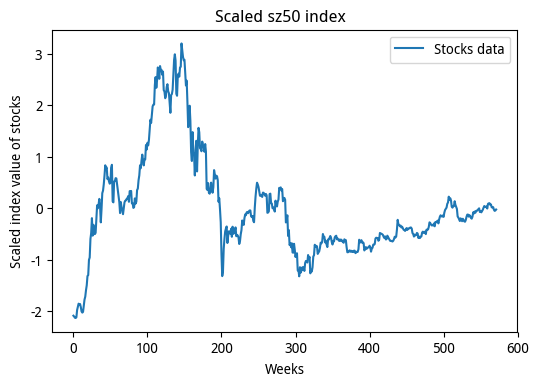

In [13]:
# plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled sz50 index  ')
plt.xlabel('Weeks')
plt.ylabel('Scaled index value of stocks')
plt.plot(scaled_traindata, label='Stocks data')
plt.legend()
plt.show()

In [14]:

def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

In [15]:
X, y = window_data(scaled_traindata, 7)

In [16]:

scaled_traindata_test=train_data_scaler.transform(close_test)

X_test,y_test=window_data(scaled_traindata_test,7)

In [17]:

X_train  = np.array(X)
y_train = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (565, 7, 1)
y_train size: (565, 1)
X_test size: (136, 7, 1)
y_test size: (136, 1)


# LSTM

In [18]:
def p_tf(tf_varible):
    with tf.Session():
        return (tf_varible.eval())

In [19]:
epochs = 200
batch_size = 7

In [20]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [21]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    
    return output

In [22]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [23]:
class StockPredictionRNN(object):
    
    def __init__(self, 
                 learning_rate=0.001, 
                 batch_size=7, 
                 hidden_layer_size=512, 
                 number_of_layers=1, 
                 dropout=True, 
                 dropout_rate=0.8, 
                 number_of_classes=1, 
                 gradient_clip_margin=4, 
                 window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [24]:

tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)


In [25]:
session =  tf.Session()
session.run(tf.global_variables_initializer())

In [26]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 30) == 0:
        print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/200  Current loss: 0.07931798696517944
Epoch 30/200  Current loss: 0.017933223396539688
Epoch 60/200  Current loss: 0.0167212076485157
Epoch 90/200  Current loss: 0.013727620244026184
Epoch 120/200  Current loss: 0.011852608993649483
Epoch 150/200  Current loss: 0.011228008195757866
Epoch 180/200  Current loss: 0.011152224615216255


In [27]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [28]:
len(X_test)

136

In [29]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)


In [30]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [31]:
tests_new.__len__()

133

In [32]:
tests_new

[array([ 0.02360817], dtype=float32),
 array([-0.06789976], dtype=float32),
 array([-0.05311275], dtype=float32),
 array([-0.00301455], dtype=float32),
 array([-0.10861309], dtype=float32),
 array([-0.05664393], dtype=float32),
 array([ 0.01990384], dtype=float32),
 array([-0.00644691], dtype=float32),
 array([-0.04037355], dtype=float32),
 array([-0.0258697], dtype=float32),
 array([-0.07011548], dtype=float32),
 array([-0.04027581], dtype=float32),
 array([ 0.05527591], dtype=float32),
 array([ 0.07538919], dtype=float32),
 array([ 0.07494057], dtype=float32),
 array([ 0.03593262], dtype=float32),
 array([ 0.03050978], dtype=float32),
 array([ 0.00918463], dtype=float32),
 array([-0.00823495], dtype=float32),
 array([-0.0348857], dtype=float32),
 array([-0.0522978], dtype=float32),
 array([-0.11237681], dtype=float32),
 array([-0.1139781], dtype=float32),
 array([-0.07792844], dtype=float32),
 array([-0.04719502], dtype=float32),
 array([-0.09025732], dtype=float32),
 array([-0.05043

In [33]:
len(sup)

560

In [34]:
test_results = []

all_data_number=len(sup)+len(tests_new)
for i in range(all_data_number):
    
    test_start=len(sup)
    
    if i >=test_start :

        test_results.append(tests_new[i-test_start])
    else:
        test_results.append(None)


In [35]:
# # plt.figure(figsize=(16, 7)) 
# plt.plot(scaled_traindata, label='ALL data')
# plt.plot(sup, label='Training data')
# plt.plot(test_results, label='Testing data')
# plt.ylabel('scaled close')
# plt.xlabel('number of data points')
# plt.legend()
# plt.show()

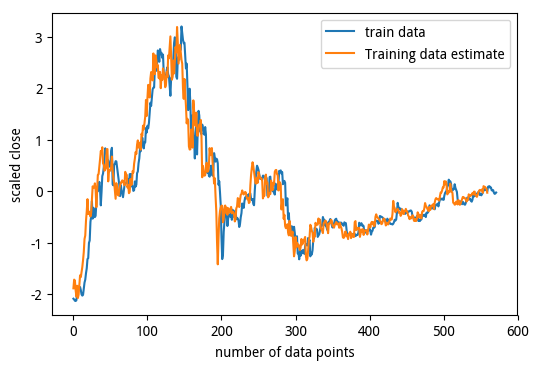

In [41]:
# plt.figure(figsize=(16, 7)) 
plt.plot(scaled_traindata, label='train data')
plt.plot(sup, label='Training data estimate')
# plt.plot(test_results, label='Testing data')
plt.ylabel('scaled close')
plt.xlabel('number of data points')
plt.legend()
plt.show()

In [49]:
len(y_test)

136

In [47]:
len(tests_new)

133

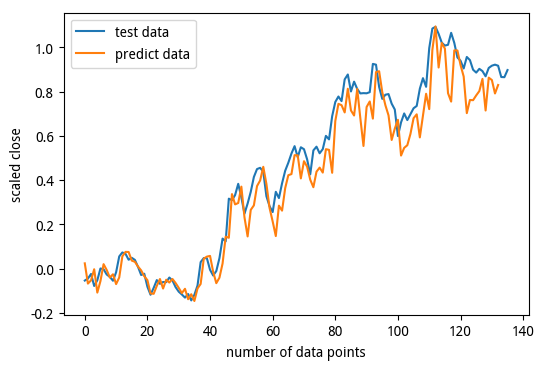

In [50]:
# plt.figure(figsize=(16, 7)) 
plt.plot(y_test , label='test data')
# plt.plot(sup, label='Training data')
plt.plot(tests_new, label='predict data')
plt.ylabel('scaled close')
plt.xlabel('number of data points')
plt.legend()
plt.show()

In [38]:
session.close()